\textbf{Main Work}:
1. In this `jupyter notebook`, we are going to change the fitness function calculation way. Since in `Version 1`, we use MSE as our main fitness function and then add L2-Norm of integration as regularization, and considering the data noise impact, we are going to use Normalized Root Mean Square Error shown in Equation \ref{eq: NRMSE} as the main error, but we need to use the total population number to average it. 
$$
NRMSE = \frac{RMSE \sqrt{\frac{n}{n-1}}}{\sigma_t} = \sqrt{\frac{\sum\limits_{i=1}^{n} (y - f(x_i))^2}{\sum\limits_{i=1}^{n}(y_i - \bar{t})^2}}
\label{eq: NRMSE}
$$
where $\bar{t}$ and $\sigma_t$ are, respectively, the mean and the standard deviation of the target output vector $t$.
2. In the evaluate function, i.e., `evalSymbReg` in the `BaseSymReg` class, we add `try-except-finally` clause to avoid number function. For example, we would gain the number, like 2.3455, as a function, i.e., individual in the population. Obviously, `func(points)` is a number which does not fit the dimension. So we change the way to calculate the integration. 

# Import Necessary Packages

In [1]:
import os

import time
import operator
import math
import random
import sympy
import multiprocessing
import numpy as np
import pandas as pd

# Plot the binary tree
import pygraphviz as pgv

import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats as cal_stats
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
from scipy import integrate
from IPython.display import Image, display, Latex
from sklearn import metrics
from sklearn import model_selection
# from utils import createDataDic  # Self-mdae function stored in python file

# from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import sys

In [2]:
sys.path.append("../")
from utils import createDataDic  # Self-mdae function stored in python file

In [3]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
config = {
    "font.family":'Times New Roman',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "axes.titlesize": 24
}
rcParams.update(config)


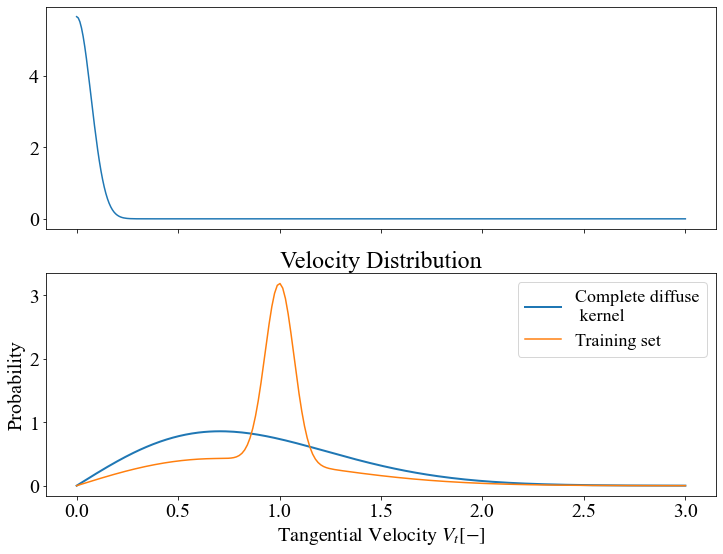

In [4]:
class CreateData():
    def __init__(self, alpha=0.9, vi=-0.5, traing_range=[-4, 4]):
        self.alpha = alpha
        self.VI = vi
        self.x_lower = traing_range[0]
        self.x_upper = traing_range[1]
    
    def diracFunc(self, x):
        """Dirac Delta Function."""
#         return 17.85*np.exp(-x**2/0.001)
        return 5.641895835477563*np.exp(-x**2/0.01)
#         return 0.564202043815939*np.exp(-x**2)
#         return 1.2615662610100802*np.exp(-5*x**2)
#         return 1.7841241161527714*np.exp(-10*x**2)
#         return 2.5231325220201604*np.exp(-20*x**2)
#         return 2.8209479177387813*np.exp(-25*x**2)
#         return 3.0901936161855166*np.exp(-30*x**2)
    
    def theoDataNormal(self, x):
        """Tangential velocity part of complete diffuse kernel."""
        f1 = 2* x* np.exp(-np.power(x, 2))
        f2 = self.diracFunc(self.VI + x)

        return f1, self.alpha*f1 + (1-self.alpha)*f2

    def trainingNormal(self, x):
        random_state = np.random.RandomState(0)
        diffuse_y, y = self.theoDataNormal(x)

        y_new = []
        for i, j in zip(x, y):
            if j >= 1e-2:
                noise = random_state.randn() 
                j = j + 0.0 * noise
            y_new.append(j)
            
        return diffuse_y, y, y_new
    
    def plotData(self):
        """
        @diffuse_y: Complete diffuse kernel
        @maxwellian_y: Complete diffuse kernle plus Specular kernel
        @noised_y: maxwellian_y plus noise.
        """
        x1 = np.linspace(self.x_lower, 0.4, 50,endpoint=False)
        x2 = np.linspace(0.4, 0.6, 70, endpoint=False)
        x3 = np.linspace(0.6, self.x_upper, 180)
        x = np.hstack((np.hstack((x1, x2)), x3))
        
        diffuse_y, maxwellian_y, noised_y = self.trainingNormal(x)
        noised_y = np.array(noised_y)
        noised_y = 1 / integrate.simps(noised_y, x) * noised_y
        fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
        axes[0].plot(x, self.diracFunc(x))
        
        axes[1].plot(x, diffuse_y, label="Complete diffuse\n kernel", linewidth=2)
#         axes[1].plot(x, maxwellian_y, label='Maxwellian kernel', linewidth=2, c='r')
        axes[1].plot(x, noised_y, label="Training set", linewidth=1.5)
        axes[1].set_xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
        axes[1].set_ylabel("Probability")
        axes[1].set_title("Velocity Distribution")
        axes[1].legend(fontsize=18)
        plt.show()
        
        return x, maxwellian_y, noised_y
    
    def plotComparison(self):
        """Plot the Training set, theoretical data, symbolic data."""
        x = np.linspace(0, 4, 400)
        m, = x.shape
        sym_func = lambda v: v*np.exp(-v**2) + 3.037*v*np.exp(-2*v**2) 
        sym_y = sym_func(x)
        print("Integration: {}".format(integrate.simps(sym_y, x)))
        diffuse_y, maxwellian_y, noised_y = self.trainingNormal(x)
        scores = np.sqrt(np.sum((noised_y-sym_y)**2 )/ (m-2)) # 0.0532
        print("Scores: {:.4f}".format(scores))
        
        fig = plt.figure(figsize=(7, 5), dpi=600)
        plt.plot(x, np.abs(noised_y), label="Training set", linewidth=2, c='#0e72cc')
#         plt.plot(x, label="Theoretical data", linewidth=2, c="#6ca30f")
        plt.plot(x, sym_y, label="Symbolic data", linewidth=2, c="#f59311")
        plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")
        plt.ylabel("Probability")
        plt.title("Velocity Distribution")
        plt.legend(fontsize=18)
        plt.savefig("./DEAP_Maxwellian_normal.png")
        plt.show()
        
        
VI = -1
alpha = 0.5
data_object = CreateData(alpha=alpha, vi=VI, traing_range=[0, 3])
X, theo_y, noised_y = data_object.plotData() # theo_y:Maxwellian_kernel, noised_y:
theo_y = 1 / integrate.simps(theo_y, X) * theo_y
# noised_y = 1 / integrate.simps(noised_y, X) * noised_y
# data_object.plotComparison()

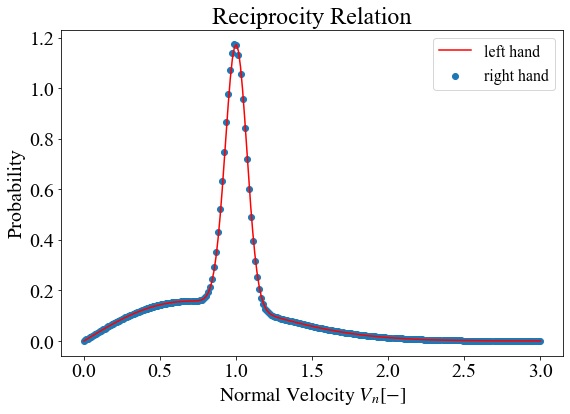

(0.36693485326646313, 0.3678794411714424)

In [5]:
def theoDataNormalNeg(x):
    def diracFunc(x):
#         return 17.85*np.exp(-x**2/0.001)
        return 5.641895835477563*np.exp(-x**2/0.01)
#         return 0.564202043815939*np.exp(-x**2)
#         return 1.2615662610100802*np.exp(-5*x**2)
#         return 1.7841241161527714*np.exp(-10*x**2)
#         return 2.5231325220201604*np.exp(-20*x**2)
#         return 2.8209479177387813*np.exp(-25*x**2)
#         return 3.0901936161855166*np.exp(-30*x**2)
    f1 = 2* (-VI)* np.exp(-np.power(VI, 2))
    return alpha*f1 + (1-alpha)*diracFunc(VI+x)


righthand_theo = X*np.exp(-X**2)*theoDataNormalNeg(X)
lefthand_theo = np.abs(VI)*np.exp(-VI**2)*theo_y
plt.figure(figsize=(9, 6))
plt.plot(X, lefthand_theo, label="left hand", c='r')
plt.scatter(X, righthand_theo, label="right hand")
plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")
plt.ylabel("Probability")
plt.title("Reciprocity Relation")
plt.legend(fontsize=16)
plt.savefig("./DEPA_Maxwellian_normal_detailed_balance_theo.png")
plt.show()

integrate.simps(righthand_theo, X), integrate.simps(lefthand_theo, X)

# DEAP Numpy
1. At the first stage, we use x_train and theo_y, i.e., the theoretical data without noise to test whether DEAP works for our idea. \textbf{NOTE}: The data structure is numpy.ndarray, which should be careful when creating corresponding  parts in DEAP. 
## DEAP SR Pipeline


In [6]:
# Tangential part
#A, B = V.squeeze(), PROB.squeeze()
# Normal part
#A, B = V_NORMAL[:, np.newaxis], PROB_NORMAL[:, np.newaxis]
# A, B = V_NORMAL.squeeze(), PROB_NORMAL.squeeze()
A, B = X.squeeze(), noised_y.squeeze()
# TEST_DATA = {
#     "X": X_test, 
#     "y": y_test
# }

In [7]:
# Define new functions
def _protectedDiv(left, right):
    with np.errstate(divide='ignore',invalid='ignore'):
        x = np.divide(left, right)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 1
            x[np.isnan(x)] = 1
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x

def _protectedExp(x):
    """
    Clourse of exp for large result.
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        exp_f = np.exp(x**2)
#         exp_f = np.exp(x)
        return np.where(exp_f > 8.8e6, 0, exp_f)
    
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(np.add, 2, name="add")
pset.addPrimitive(np.subtract, 2, name="sub")
pset.addPrimitive(np.multiply, 2, name="mul")
pset.addPrimitive(_protectedDiv, 2, name="div")
# pset.addPrimitive(np.square, 1, name='square')
pset.addPrimitive(_protectedExp, 1, name="exp")
# pset.addPrimitive(np.negative, 1, name="neg")

pset.addEphemeralConstant(
        "rand_round", lambda: np.round_(random.uniform(0, 5), decimals=3))
pset.renameArguments(ARG0='x')

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [9]:
def varAnd(population, toolbox, cxpb, mutpb):
    """Part of an evolutionary algorithm applying only the variation part
    (crossover **and** mutation). The modified individuals have their
    fitness invalidated. The individuals are cloned so returned population is
    independent of the input population.
    -------------------
    Variables: 
        :param population: A list of individuals to vary.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the 
                evolution operators.
        :param cxpb: The probability of mating two individuals. 
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple 
                    mutation mechanism. The key tis the muytation way, the value
                    is the mutation probability.
    ------------------
    :returns: A list of varied individuals that are independent of their
              parents.
    """
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(
                offspring[i - 1], offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values
        elif (random.random() >= cxpb) and (
                random.random() < cxpb + 0.1):
            offspring[i - 1], offspring[i] = toolbox.p_leaf_cx(
                offspring[i - 1], offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate_grow(offspring[i])
            del offspring[i].fitness.values
        elif (random.random() >= mutpb) and random.random() < (mutpb + 0.05):
            offspring[i], = toolbox.mutate_full(offspring[i])
            del offspring[i].fitness.values
    return offspring


def AdaptiveControl(old_var, new_var):
    """This is the adapative contol of crossover and mutation based on variance
    in each generation."""
#     slope = new_var - old_var
    slope = new_var
    # Dynamic limit
#     limit_range = 0.005
    slope_min, slope_max = 0, 1#-limit_range, limit_range
    
    #Give intial thresholds for crossover and mutation
    pm_min, pm_max, pc_min, pc_max = 0.025, 0.25, 0.5, 0.8
    
    # Calculate new probability of crossover and mutation, define the middle
    # point when slope equals to zero.
    pc = pc_min + (pc_max - pc_min) / (slope_min - slope_max) * (slope - slope_max)
    pm = pm_min + (pm_max - pm_min) / (slope_max - slope_min) * (slope - slope_min)
    
    if pc > pc_max:
        pc = pc_max
    if pc < pc_min:
        pc = pc_min
    if pm > pm_max:
        pm = pm_max
    if pm < pm_min:
        pm = pm_min

    return pc, pm


def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm reproduce the simplest evolutionary algorithm as
    presented in chapter 7 of [Back2000]_.
    -----------------
    Variables:
        :param population: A list of individuals.
        :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                        operators.
        :param cxpb: The probability of mating two individuals.
        :param mutpb: The probability of mutating an individual. This parameter 
                    should be a dictionary, so taht we could use multiple
                    mutation mechanism. The key tis the muytation way, the 
                    value is the mutation probability.
        :param ngen: The number of generation.
        :param stats: A :class:`~deap.tools.Statistics` object that is updated
                      inplace, optional.
        :param halloffame: A :class:`~deap.tools.HallOfFame` object that will
                           contain the best individuals, optional.
        :param verbose: Whether or not to log the statistics.
    ----------------
    :returns: The final population
    :returns: A class:`~deap.tools.Logbook` with the statistics of the
              evolution
    """
    print_rates = False
    cxpb, mutpb = 0.8, 0.1
    scale_num = 10
    
    old_fitness = np.array(list(map(toolbox.evaluate, population)))
#     print(old_fitness.squeeze())
    z, (min_value, max_value), mean_fit, var_fit, _, _ = cal_stats.describe(old_fitness.squeeze())
#     var_fit = statistics.variance(old_fitness.squeeze())
    old_gdm = mean_fit / max_value
    old_gdm = scale_num * old_gdm 
#     old_var = var_fit / scale_num
    
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))
        
        if print_rates:
            print("GDM: {}, cx:{}, mut:{}".format(old_gdm, cxpb, mutpb))
            
        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring
        
        pop_fitness = np.array(list(map(toolbox.evaluate, population)))
        z, (min_value, max_value), mean_fit, var_fit, _, _ =cal_stats.describe(pop_fitness)
#         var_fit = statistics.variance(pop_fitness.squeeze())
        new_gdm = mean_fit / max_value
        new_gdm = new_gdm * scale_num
#         new_var = var_fit / scale_num
        
        # update cxpb and mutpb
#         cxpb, mutpb = AdaptiveControl(old_var, new_var)
        cxpb, mutpb = AdaptiveControl(old_gdm, new_gdm)
        old_gdm = new_gdm
        
#         old_var = new_var
        
        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        
        # Set stopping criteria
        if record['fitness']['min'] < 0.0001:
            print('The stopping criteria is met, with fitness {}'.format(record['fitness']['min']))
            break 

    return population, logbook, record


<ipython-input-7-0c913dba7da7>:17: RuntimeWarning: overflow encountered in exp
  exp_f = np.exp(x**2)


   	      	           fitness            	         size         
   	      	------------------------------	----------------------
gen	nevals	gen	min       	nevals	gen	min	nevals
0  	2000  	0  	0.00277758	2000  	0  	2  	2000  
1  	1739  	1  	0.00268892	1739  	1  	1  	1739  
2  	1678  	2  	0.00267338	1678  	2  	1  	1678  
3  	1667  	3  	0.00261042	1667  	3  	1  	1667  
4  	1690  	4  	0.00261042	1690  	4  	1  	1690  
5  	1659  	5  	0.00259724	1659  	5  	1  	1659  
6  	1665  	6  	0.00250701	1665  	6  	1  	1665  
7  	1697  	7  	0.00250701	1697  	7  	1  	1697  
8  	1678  	8  	0.002492  	1678  	8  	1  	1678  
9  	1695  	9  	0.00245221	1695  	9  	1  	1695  
10 	1656  	10 	0.00194543	1656  	10 	1  	1656  
11 	1705  	11 	0.00194543	1705  	11 	1  	1705  
12 	1680  	12 	0.00220498	1680  	12 	1  	1680  
13 	1716  	13 	0.00220498	1716  	13 	1  	1716  
14 	1706  	14 	0.00209135	1706  	14 	1  	1706  
15 	1710  	15 	0.00209135	1710  	15 	1  	1710  
16 	1680  	16 	0.00209135	1680  	16 	1  	1680  
17 	17

166	1673  	166	0.000972961	1673  	166	1  	1673  
167	1683  	167	0.000972961	1683  	167	1  	1683  
168	1739  	168	0.000972961	1739  	168	1  	1739  
169	1697  	169	0.000931059	1697  	169	2  	1697  
170	1665  	170	0.000931059	1665  	170	3  	1665  
171	1685  	171	0.000931059	1685  	171	1  	1685  
172	1714  	172	0.000931059	1714  	172	3  	1714  
173	1706  	173	0.000876581	1706  	173	1  	1706  
174	1702  	174	0.000866239	1702  	174	1  	1702  
175	1681  	175	0.000876581	1681  	175	1  	1681  
176	1740  	176	0.000876581	1740  	176	1  	1740  
177	1741  	177	0.000876581	1741  	177	1  	1741  
178	1694  	178	0.000876581	1694  	178	1  	1694  
179	1703  	179	0.000876581	1703  	179	1  	1703  
180	1717  	180	0.000846623	1717  	180	1  	1717  
181	1698  	181	0.000846623	1698  	181	1  	1698  
182	1730  	182	0.000846623	1730  	182	1  	1730  
183	1686  	183	0.000846623	1686  	183	1  	1686  
184	1690  	184	0.000846623	1690  	184	2  	1690  
185	1746  	185	0.000846623	1746  	185	1  	1746  
186	1686  	186	0.000

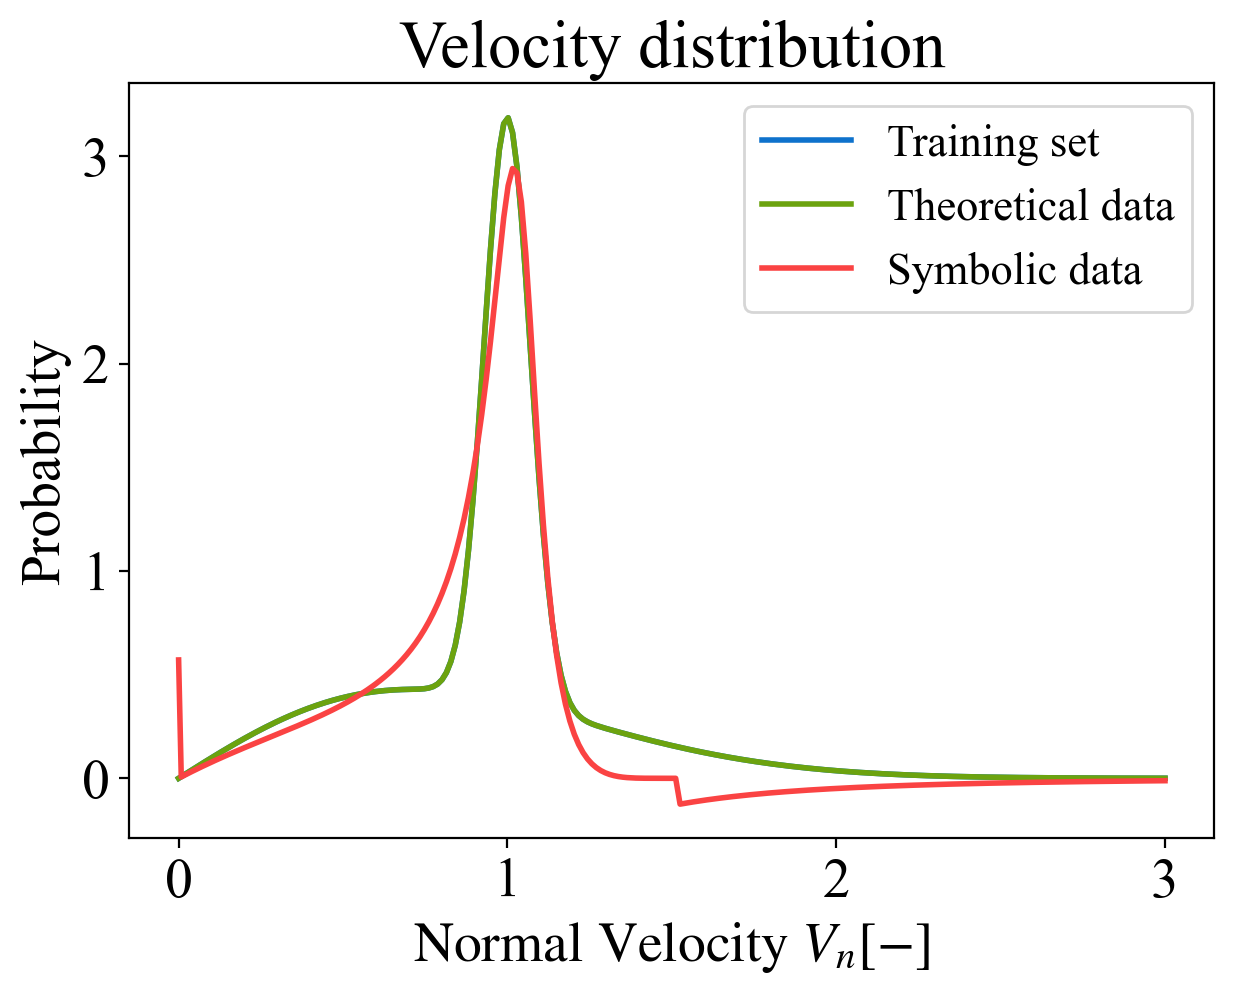

Theoretical R^2 = 0.138


<ipython-input-7-0c913dba7da7>:17: RuntimeWarning: overflow encountered in exp
  exp_f = np.exp(x**2)


-1.142*x/(x*(x**4 + 2*x**2 - exp(0.0515123086601051*x**2*(x + exp(x**2))**2)) - 1.364)

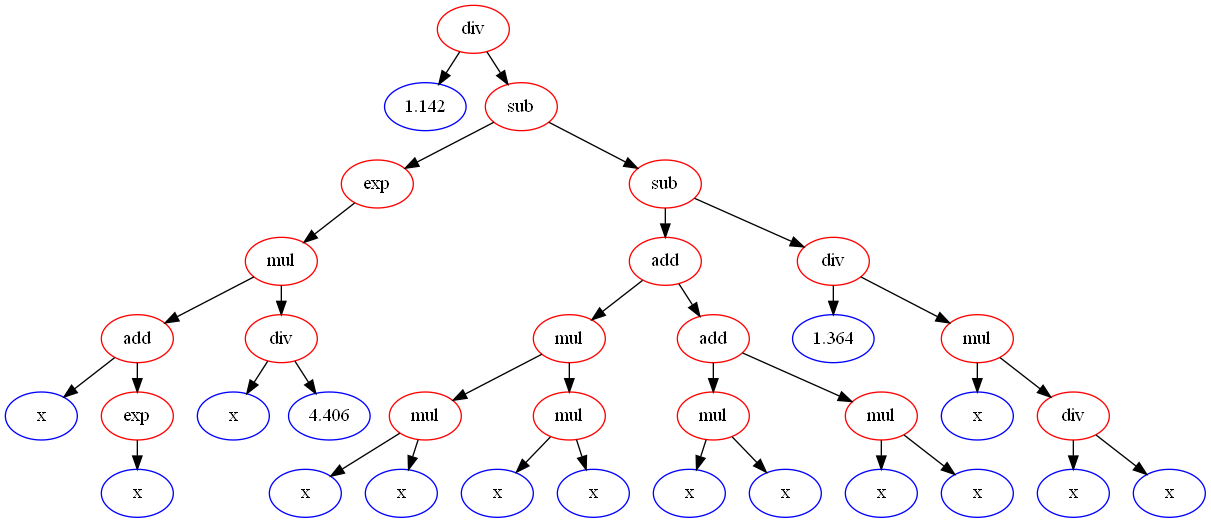

Total Time: 777.038 s


In [10]:
class BaseSymReg():
    """
    Variables:
        _Data_info: Dictionary
            It should be the structure like the following example, 
            Data_info = {
                "X_train": V_NORMAL,  # training  X
                "y_train": PROB_NORMAL,  # training y
                "fit": y_fit_normal,  # fit data, but for empirical data, it could be None
                "fit_para": fit_parameters_normal,  # same as before
                "theoretical": y_theo_normal,  # theoretical data, should be None for real
            }
            Here it contains the X, y we want to fit in our job. 
        _mutation_dic: Dictionary
            It should be the structure like *mutation_dic = {'full': 0.05, 'grow': 0.1}*.
            Since we only include two mutation tree generation ways, i.e., full
            and grow, the mutation probability should noly be the configuration
            like this.
        _pset: `gplean.gp.PrimitiveSet`
            It is a primitive set containing all the functions, variables and
            constant.
        save_path: string
            It is a path to save the comparison figure.
        _generation: int, default as 20
            The generation number.
        _penelty_coeff: float, default as 0.001
            It is the coefficient before our L2 regularization, i.e., integration
            penalty.
        _height_max_value: int, default as 4
            It controls bloat problem in SR. The value here means the maximum
            length of the deepest tree.
        _pop_size: int, default as 2000
            The population size.
        _prob_cx_subtree: float, default as 0.5.
            Crossover action.
        _prob_cx_leaf: float, default as 0.1.
            Crossover action, but not the whole subtree.
        sk_kind: string
            There are two kinds of skcattering kernels, i.e. normal and
            tangential. In this class, we only accept `Normal` and `Tangential` 
            as our key word to do some analysis.
    -------------------
    NOTE: There are two global variable in this class, i.e., A and B. 
        A is the X_train, B is the y_trian or any other knid of y value.
    """
    def __init__(self,
                 Data_info,
                 mutation_dic,
                 pset,
                 save_path,
                 generation=20,
                 population_size=2000,
                 penalty_coeff=0.1,
                 height_max_value=6,
                 prob_cx_subtree=0.5,
                 prob_cx_leaf=0.1,
                 sk_kind="Normal"):
        self._Data_info = Data_info
        self._mutation_dic = mutation_dic
        self._pset = pset
        self.save_path = save_path
        self._generation = generation
        self._penelty_coeff = penalty_coeff
        self._height_max_value = height_max_value
        self._pop_size = population_size
        self._prob_cx_subtree = prob_cx_subtree
        self._prob_cx_leaf = prob_cx_leaf
        self.sk_kind = sk_kind

    def __del__(self):
        """We need to delete the instance to release the memory."""
        print("The instance has been deleted")

    def assembleGP(self, ):
        toolbox = base.Toolbox()
        toolbox.register("expr",
                         gp.genHalfAndHalf,
                         pset=self._pset,
                         min_=1,
                         max_=3)
        toolbox.register("individual", tools.initIterate, creator.Individual,
                         toolbox.expr)
        toolbox.register("population", tools.initRepeat, list,
                         toolbox.individual)
        toolbox.register("compile", gp.compile, pset=self._pset)

        def evalSymbReg(individual, points, y_true):
            """At this function, we must consider so many exceptions for
            integration."""
            # Transform the tree expression in a callable function
            func = toolbox.compile(expr=individual)
            # Evaluate the mean squared error between the expression
            y_pred = func(points)
            numerator = np.sum((y_true - y_pred)**2)
            denominator = np.sum((y_true - np.average(y_true))**2)
            error = np.sqrt(numerator / denominator) / len(points)

            try:
                """Sometimes the function could be a number."""
                inte = integrate.simps(y_pred, points)
                # print("INTE:", integrate.simps(func(points), points))
            except Exception as e:
                inte = y_pred * (np.max(points) - np.min(points))
                # print(inte)
            finally:
                L2_norm = (inte - 1)**2

            errors = error + self._penelty_coeff * L2_norm

            return errors,

        # Fitness function
        toolbox.register("evaluate",
                         evalSymbReg,
                         points=self._Data_info["X_train"],
                         y_true=self._Data_info["y_train"])
        # Selection
        toolbox.register("select", tools.selTournament, tournsize=5)
        # Crossover
        toolbox.register("mate", gp.cxOnePoint)  # Subtree crossover
        toolbox.register("p_leaf_cx",
                         gp.cxOnePointLeafBiased,
                         termpb=self._prob_cx_leaf)  # leaf crossover
        # Mutation
        toolbox.register("expr_mut_full", gp.genFull, min_=0,
                         max_=2)  # The depth of leaf are strict constrainted
        toolbox.register("expr_mut_grow", gp.genGrow, min_=0,
                         max_=3)  # The depth is varying
        toolbox.register("mutate_full",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_full,
                         pset=self._pset)
        toolbox.register("mutate_grow",
                         gp.mutUniform,
                         expr=toolbox.expr_mut_grow,
                         pset=self._pset)

        # Bloat control: It is useful for crossover and mutation
        toolbox.decorate(
            "mate",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_full",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "mutate_grow",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))
        toolbox.decorate(
            "p_leaf_cx",
            gp.staticLimit(key=operator.attrgetter("height"),
                           max_value=self._height_max_value))

        return toolbox

    def score(self, x, y, best_tree):
        """This is a test function to give R^2 value as the score, where
        R^2 = (1 - U/V), which means R^2 is higher when the model's performance
        is better.
        """
        func = gp.compile(str(best_tree), pset=self._pset)
        y_pred = func(x)
        m = x.shape[0]

        return np.sqrt(np.sum((y_pred - y)**2 ) / (m - 2))

    def main_program(self):
        random.seed(0)

        # 1. Prepare toolbox
        toolbox = self.assembleGP()

        # 2. Getting population
        pop = toolbox.population(n=self._pop_size)
        hof = tools.HallOfFame(1)

        # 3. Prepare log information
        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
        mstats.register("min", np.min)

        # 4. Evolution
        pop, log, record = eaSimple(
            pop,
            toolbox,
            cxpb=self._prob_cx_subtree,
            mutpb=self._mutation_dic,
            ngen=self._generation,
            stats=mstats,
            halloffame=hof,
            verbose=True
        )  # record gives the minimum fitness of each generation

        return pop, log, hof, record

    def _timeTransfer(self, total_time):
        """Transfer time into minutes and seconds"""
        minute = total_time // 60
        second = total_time % 60

        return minute, second

    def treeTransfer(self, hof):
        """
        Transfer the optimal individual into symbolc expression using string
        format.
        ----------------------
        hof_tree_expr: It is a simplified symbolic mathematical expression.
        hof_tree: It is a gp.PrimitiveTree structure, which is not a string
            that could be compiled to a function using gp.compile. Thus you need
            to use str(hof_tree) so that you could compile it.
        """
        converter = {
            'sub': lambda x, y: x - y,
            'div': lambda x, y: x / y,
            'mul': lambda x, y: x * y,
            'add': lambda x, y: x + y,
            'neg': lambda x: -x,
            'abs': lambda x: sympy.Abs(x),
            'pow': lambda x, y: x**y,
            'sin': lambda x: sympy.sin(x),
            'cos': lambda x: sympy.cos(x),
            'inv': lambda x: 1 / x,
            'sqrt': lambda x: x**0.5,
            'exp': lambda x: sympy.exp(x**2),
            'square': lambda x: x**2
        }  # Converter set

        hof_tree = gp.PrimitiveTree(hof)[0]
        hof_tree_str = str(gp.PrimitiveTree(hof)[0])
        hof_tree_expr = sympy.sympify(hof_tree_str, locals=converter)
        hof_tree_expr = sympy.simplify(
            hof_tree_expr)  # simplify the expression

        return hof_tree_expr, hof_tree

    def plotComparison(self, best_tree):
        """
        best_tree: It shoule be PrimitiveTree structure, which should be
            converted into str here, so that the compilation could be made.
        """
        font_dict = {'family': 'Times New Roman', 'size': 20}
        title_dict = {'family': 'Times New Roman', 'size': 24}

        X = self._Data_info["X_train"]
        noised_y = self._Data_info["y_train"]
        theo_y = self._Data_info["theoretical"]
            
        best_func = gp.compile(str(best_tree), self._pset)
        best_y = [best_func(x) for x in X]


        fig = plt.figure(figsize=(7, 5), dpi=200)

        plt.plot(X, noised_y, label='Training set', linewidth=2, c='#0e72cc')
        plt.plot(X, theo_y, label="Theoretical data", linewidth=2, c='#6ca30f')
        plt.plot(X, best_y, label="Symbolic data", linewidth=2, c='#fa4343')
        plt.xlabel('$\mathrm{Normal\ Velocity}\ V_n[-]$')
#         plt.xlabel('Normal Velocity', fontdict=font_dict)
        plt.xticks(fontsize=20)
        plt.ylabel('Probability')
        plt.yticks(fontsize=20)
        plt.title('Velocity distribution')
        plt.legend(fontsize=16)

        plt.savefig(self.save_path)
        plt.show()
        
        theo_r2 = self.score(X, theo_y, best_tree)
        print("Theoretical R^2 = {:.3f}".format(theo_r2))
        
    def treePlot(self, best_tree, path):
        nodes, edges, labels = gp.graph(best_tree)

        g = pgv.AGraph(ranksep="0.3", directed=True,strict=True)
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        g.layout(prog="dot")

        for i in nodes:
            node = g.get_node(i)
            # node.attr["label"] = labels[i]
            if isinstance(labels[i], float) or isinstance(labels[i], int):
                node.attr["label"] = np.round_(labels[i], decimals=3)
                node.attr['color'] = 'blue'
            else:
                node.attr["label"] = labels[i]
                if len(labels[i]) > 1:
                    node.attr['color'] = 'red'
                else:
                    node.attr['color'] = 'blue'

        g.draw(path)
        display(Image(path, height=150))


if __name__ == "__main__":
    time_start = time.time()

    mutation_dic = {'full': 0.05, 'grow': 0.1}

   
    # Normal infor
    Data_info = {
        "X_train": X,
        "y_train": noised_y,
        "theoretical": theo_y,
    }
    fig_path = './DEAP_Maxwellian_normal.png'
    baseSR_object = BaseSymReg(Data_info=Data_info,
                               mutation_dic=mutation_dic,
                               pset=pset,
                               save_path=fig_path,
                               generation=200,
                               population_size=2000,
                               penalty_coeff=0.00,
                               prob_cx_subtree=0.5,
                               prob_cx_leaf=0.1,
                               sk_kind="Normal")

    # baseSR_object.parameterTest()
    pop, log, hof, record = baseSR_object.main_program()

    best_sr_expr, best_tree = baseSR_object.treeTransfer(hof)

    baseSR_object.plotComparison(best_tree)
    display(best_sr_expr)  # display the expression
    tree_path = "./DEAP_normal_tree_color.png"
    baseSR_object.treePlot(best_tree, tree_path) 
    # Getting scores
    #r_2 = baseSR_object.score(TEST_DATA["X"], TEST_DATA["y"], best_tree)
    #print("R^2 = {:.3f}".format(r_2))

    time_end = time.time()
    total_time = time_end - time_start
    print("Total Time: {:.3f} s".format(total_time))

    # 0.00585
    # 0.00537 for penalty 0.001

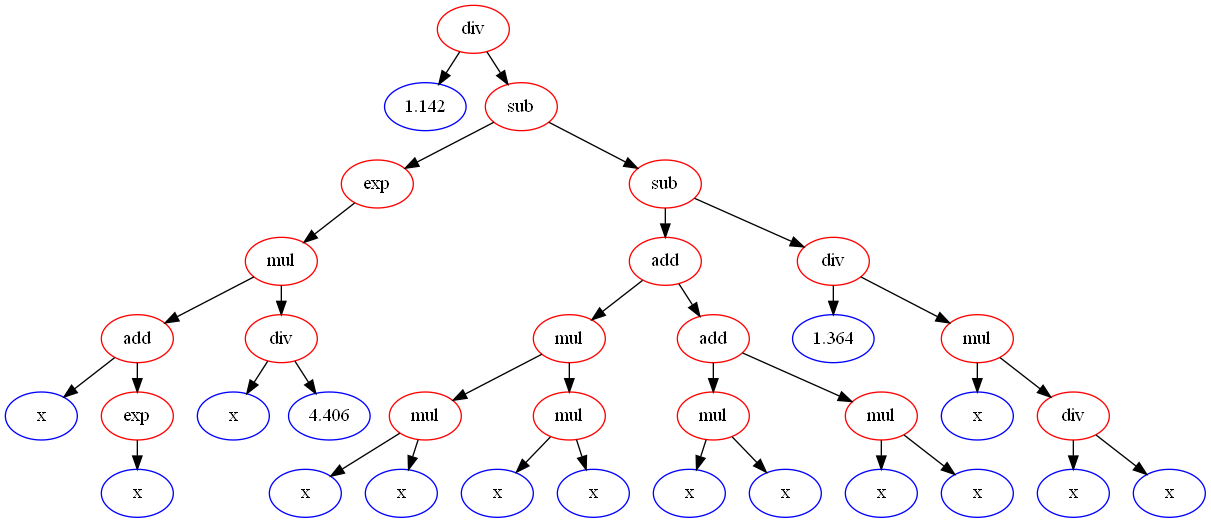

In [11]:
tree_path = "./DEAP_normal_tree_color.png"
baseSR_object.treePlot(best_tree, tree_path)

In [12]:
key="Normal"
def func(x):
    return 2.0276211760478*x*np.exp(-x**2)


# func = gp.compile(best_tree_normal, pset=pset)
y_sym = func(V_NORMAL)
# y_sym = symbolicData(X_NORMAL[:, 0], X_NORMAL[:, 1])
# y_Yam = Yamamoto(X_TRAIN[:, 0], X_TRAIN[:, 1])
fig = plt.figure(figsize=(7, 5), dpi=600)
plt.plot(V_NORMAL, PROB_NORMAL, label="Training set", c='#0e72cc')
plt.plot(V_NORMAL, y_theo_normal, 'r-.', label='Theoretical data', linewidth=1, marker="*", markevery=10)
# plt.plot(X_TRAIN[:, 0], y_Yam, 'r-.', label="Yamamoto kernel", linewidth=1, marker="*", markevery=10)
plt.plot(V_NORMAL, y_sym, label="Symbolic data", linewidth=1.5, c='#f59311')
if key == "Tangential":
    plt.xlabel("$\mathrm{Tangential\ Velocity}\ V_t [-]$")
elif key == "Normal":
    plt.xlabel("$\mathrm{Normal\ Velocity}\ V_n [-]$")

plt.ylabel("Probability")
plt.title("Velocity Distribution")
plt.legend(fontsize=18)
plt.savefig("./DEAP_complete_diffuse_kernel_normal.png", bbox_inches="tight")

plt.show()

NameError: name 'V_NORMAL' is not defined

In [ ]:
func = gp.compile(str(best_tree), pset)
# Evaluate the mean squared error between the expression
y_p = func(V_NORMAL)
np.sqrt(np.average((y_theo_normal - y_p)**2))

## Cross Validation

In [ ]:
def plotCvIndices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object.
    -----------
    cv: It is a cross validation object.
    """
    if X.ndim == 1:
        m, = X.shape  # This should be pay attention when X is 2D
    else:
        m, _ = X.shape

    mask = {'train': {}, 'test': {}}  # Gain the mask after split
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1  # testing
        indices[tr] = 0  # training
        mask['train'][str(ii + 1) + "_layer"] = tr
        mask['test'][str(ii + 1) + "_layer"] = tt

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices,
                   marker='_',
                   lw=lw,
                   cmap=cmap_cv,
                   vmin=-.2,
                   vmax=1.2)

    # Formatting
    yticklabels = list(np.arange(n_splits) + 1)
    ax.set(yticks=np.arange(n_splits) + .5,
           yticklabels=yticklabels,
           ylim=[n_splits + 0.2, -.2],
           xlim=[0, m])  # the limit should be set
    ax.set_xlabel(xlabel='Sample index', fontdict={"size": 16})
    ax.set_ylabel(ylabel="CV iteration", fontdict={"size": 16})
    ax.tick_params(axis='both', labelsize=16)
    ax.set_title('{}'.format(type(cv).__name__), fontsize=20)

    plt.savefig('./figure/diffuse kernel crossValidation.png')

    return ax, mask


def crossValidation(X, Y, n_splits=5):
    """In this class, A is the X, B is the y， A and B are all global variables, 
    should be modified. Here we use X and Y to replace A and B, respectively."""
    if X.ndim == 1:
        n_points, = X.shape
    else:
        n_points, _ = X.shape

    # Plot Sampling Graph
    fig, ax = plt.subplots()
    cv = model_selection.ShuffleSplit(n_splits, test_size=0.1, random_state=0)

    percentiles_classes = [.1, .3, .6]
    y = np.hstack([[ii] * int(n_points * perc)
                   for ii, perc in enumerate(percentiles_classes)])
    groups = np.hstack([[ii] * 10 for ii in range(int(n_points / 10))])
    # gain the mask and axes object
    ax, mask = plotCvIndices(cv, X, y, groups, ax=ax, n_splits=n_splits, lw=15)
    ax.legend([Patch(color=cmap_cv(.8)),
               Patch(color=cmap_cv(.02))], ['Testing set', 'Training set'],
              loc=(1.02, .8),
              fontsize=16)
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=1)

    # Extract the train and test data
    train_mask, test_mask = mask["train"], mask["test"]
    
    for key, train_index, in train_mask.items():
        test_index = test_mask[key]
        train_set_X, train_set_y = X[train_index], Y[train_index]
        test_set_X, test_set_y = X[test_index], Y[test_index]

        # Sort the data along x direction
        sort_mask = np.argsort(train_set_X)
        train_set_X = train_set_X[sort_mask]
        train_set_y = train_set_y[sort_mask]

        mutation_dic = {'full': 0.05, 'grow': 0.1}
        Data_info = {
            "X_train": train_set_X,
            "y_train": train_set_y,
            "fit": y_fit_normal,
            "fit_para": fit_parameters_normal,
            "theoretical": y_theo_normal,
        }  # there are some global variable
        fig_path = './figure/DEAP_normal cross validation' + str(key) + ".png"

        baseSR_object = BaseSymReg(Data_info=Data_info,
                                   mutation_dic=mutation_dic,
                                   pset=pset,
                                   save_path=fig_path,
                                   generation=20,
                                   population_size=2000,
                                   penalty_coeff=0.001,
                                   prob_cx_subtree=0.5,
                                   prob_cx_leaf=0.1,
                                   sk_kind="Normal")

        # baseSR_object.parameterTest()
        pop, log, hof, record = baseSR_object.main_program()

        best_sr_expr, best_tree = baseSR_object.treeTransfer(hof)

        baseSR_object.plotComparison(best_tree)
        display(best_sr_expr)  # display the expression

        r_2 = baseSR_object.score(test_set_X, test_set_y, best_tree)
        print("Testing R^2 = {:.3f}".format(r_2))


# Run cross validation process
crossValidation(A, B)